In this project I'll attempt to build models to identify the category of a given news title.

# Goals:
 - Feature generation. `Bag of Words` vs `Latent Semantic Analysis`
 - Predict outcome variables - `Supervised Learning` (classification)
 
# Dataset: 
URL: https://www.kaggle.com/uciml/news-aggregator-dataset

This dataset contains headlines, URLs, and categories for 422,937 news stories collected by a web aggregator between March 10th, 2014 and August 10th, 2014.
News categories included in this dataset include business; science and technology; entertainment; and health. Different news articles that refer to the same news item (e.g., several articles about recently released employment statistics) are also categorized together.

In [1]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from time import time
import spacy
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import make_scorer, normalized_mutual_info_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

C:\Users\hafeez_poldz\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## 1. Explarotary Data Analysis 
Quick overview of the dataset

In [2]:
data = pd.read_csv(r'C:\Users\hafeez_poldz\Desktop\Thinkful\Projects\data\uci-news-aggregator.csv')
data.head(2)

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207


In [3]:
# checking for missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422419 entries, 0 to 422418
Data columns (total 8 columns):
ID           422419 non-null int64
TITLE        422419 non-null object
URL          422419 non-null object
PUBLISHER    422417 non-null object
CATEGORY     422419 non-null object
STORY        422419 non-null object
HOSTNAME     422419 non-null object
TIMESTAMP    422419 non-null int64
dtypes: int64(2), object(6)
memory usage: 25.8+ MB


## 1.1 Publishers

In [4]:
# this function will highlight keywords to improve the readability
def highlight(x):
    """Bold the string to help get the print reader's attention.
    
    Parameters
    ----------
    x : str
        String to be decorated with bold.
    
    Returns
    -------
    str
        The string in bold.
    """
    yellow= '\x1b[31;4m'
    stop = '\x1b[0m'
    return yellow + str(x) + stop

# number of unique publishers
publishers = data['PUBLISHER'].nunique()
articles = data['TITLE'].nunique()
print("There are {} of articles published by {} publishers. Below some of the most common publishers:".format(highlight(articles),
                                                                                                             highlight(publishers)))
for key, value in Counter(data['PUBLISHER']).most_common(10):
    print("   {} posted {} articles".format(highlight(key), highlight(value)))

There are 406455 of articles published by 10985 publishers. Below some of the most common publishers:
   Reuters posted 3902 articles
   Huffington Post posted 2455 articles
   Businessweek posted 2395 articles
   Contactmusic.com posted 2334 articles
   Daily Mail posted 2254 articles
   NASDAQ posted 2228 articles
   Examiner.com posted 2085 articles
   Los Angeles Times posted 1976 articles
   GlobalPost posted 1975 articles
   RTT News posted 1798 articles


## 1.2 Articles per Category

In [5]:
# number of articles per category
print(data.groupby('CATEGORY')['TITLE'].nunique().sort_values(ascending = False))

CATEGORY
e    146952
b    111903
t    104733
m     43719
Name: TITLE, dtype: int64


`Entertainment` is the most active category followed by `Business` and `Technology`. Only 10.7% of total articles are in `Health` category.

# 2. Data Preprocessing
To continue, I need to normalize `TITLE` column. I'll define a function to remove punctuations and lowercase all the words in title. 

In [6]:
def normalize(x):
    """This function will remove the puntuations in text and lowercase all the words.
    Parameters
    ----------
    w: str
    
    Returns
    -------
    string without punctuations and uppercases
    
    """
    x = x.lower()
    
    # remove punctuation that is not word-internal (e.g., hyphens, apostrophes)
    x = re.sub('\s\W',' ',x)
    x = re.sub('\W\s',' ',x)
    
    # make sure we didn't introduce any double spaces
    x = re.sub('\s+',' ',x)
    
    return x
    
data['HEADLINE'] = [normalize(s) for s in data['TITLE']]

data['CATEGORY'] = data['CATEGORY'].astype('category')
data['CATEGORY'] = data['CATEGORY'].cat.rename_categories({'b': 'Business', 't': 'Technology', 'm':'Health', 'e':'Entertainment'})

## 2.1 Limit Data to Scope
To improve the running time, I'll pick only 10K articles per category in order not to exceed mmaximum 1000000 lenght.

In [7]:
news = data[['HEADLINE', 'CATEGORY']]
news = news.groupby('CATEGORY').head(10000).reset_index(drop = True)
news.head(2)


,HEADLINE,CATEGORY
0,fed official says weak data caused by weather ...,Business
1,fed's charles plosser sees high bar for change...,Business


# 3. Supervised Feature Generation
Supervised NLP requires a pre-labelled dataset for training and testing, and is generally interested in categorizing text in various ways. In this case I'll create `Bag of Words` containing the most-common words of categories combined. 

## 3.1 BoW
Here I'll extract the most-common 1000 words from each category corpus, store them in a list, and then eliminate duplicates.

In [8]:
names = news['CATEGORY'].value_counts().index.tolist()


t0 = time()

# Load spacy NLP object
nlp = spacy.load('en')

# A list to store common words by all authors
common_words = []

# A dictionary to store the spacy_doc object of each author
category_docs = {}

for name in names:
    # Corpus is all the text written by that author
    corpus = ""
    # Grab all rows of current category, along the 'HEADLINE' column
    category_headline = news.loc[news.CATEGORY==name,'HEADLINE']
    
    # Merge all articles in to the author's corpus
    for headline in category_headline:
        corpus = corpus + headline
    # Let Spacy parse the category's headline of text
    doc = nlp(corpus)
    
    # Store the doc in the dictionary
    category_docs[name] = doc
        
    # Filter out punctuation and stop words.
    lemmas = [token.lemma_ for token in doc
                if not token.is_punct and not token.is_stop]
        
    # Return the most common words of that author's corpus.
    bow = [item[0] for item in Counter(lemmas).most_common(1000)]
    
    # Add them to the list of words by all authors.
    for word in bow:
        common_words.append(word)

# Eliminate duplicates
common_words = set(common_words)
    
print('Total number of common words:', len(common_words))
print("done in %0.3fs" % (time() - t0))

Total number of common words: 2663
done in 54.666s


* From total of 40K common-words (10000 words for each category), 2661 are unique. 

In [9]:
# Let's see our 4 categories in the dictionary
lengths = []
for k,v in category_docs.items():
    print(highlight(k),'corpus contains',len(v),' words.')
    lengths.append(len(v))

Technology corpus contains 88802  words.
Health corpus contains 82316  words.
Entertainment corpus contains 94557  words.
Business corpus contains 83480  words.


## 3.2 Common Words to Features
Doing this step with 40K headlines will take extremely long. To reduce the running time I'll take only 1000 headlines per category. 

I'll create a feature out of each common word and then count the number of times each common word appears in each headline. Each cell will represent the number of times the lemma of the given column appears in the headline of the current row. We have over 2500 common words, and will be using 4000 headlines total. Additionaly, each headline may have a varying number of words in it. That's a lot of text to compare and count.


In [10]:
bow_counts = pd.DataFrame()
for name in names:
    # Select 1000 headlines of each category
    headlines = news.loc[news.CATEGORY==name,:][:1000]
    bow_counts = bow_counts.append(headlines)
bow_counts = bow_counts.reset_index().drop('index',1)

# Use common_words as the columns of a temporary DataFrame
df = pd.DataFrame(columns=common_words)

# Join BOW features with the category's headline
bow_counts = bow_counts.join(df)

# Initialize rows with zeroes
bow_counts.loc[:,common_words] = 0

# Fill the DataFrame with counts of each feature in each headline
t0 = time()
for i, headline in enumerate(bow_counts.HEADLINE):
    doc = nlp(headline)
    for token in doc:
        if token.lemma_.lower() in common_words:
            bow_counts.loc[i,token.lemma_.lower()] += 1
    # Print a message every X headlines
    if i % 50 == 0:
        if time()-t0 < 3600: # if less than an hour in minutes
            print("Headline ",i," done after ",round((time()-t0)/60, 2),' minutes.')
        else:
            print("Headline ",i," done after ",round((time()-t0)/60/60, 2), ' hours.')

Headline  0  done after  0.0  minutes.
Headline  50  done after  0.01  minutes.
Headline  100  done after  0.02  minutes.
Headline  150  done after  0.03  minutes.
Headline  200  done after  0.03  minutes.
Headline  250  done after  0.04  minutes.
Headline  300  done after  0.05  minutes.
Headline  350  done after  0.06  minutes.
Headline  400  done after  0.06  minutes.
Headline  450  done after  0.07  minutes.
Headline  500  done after  0.08  minutes.
Headline  550  done after  0.09  minutes.
Headline  600  done after  0.1  minutes.
Headline  650  done after  0.1  minutes.
Headline  700  done after  0.11  minutes.
Headline  750  done after  0.12  minutes.
Headline  800  done after  0.13  minutes.
Headline  850  done after  0.14  minutes.
Headline  900  done after  0.14  minutes.
Headline  950  done after  0.15  minutes.
Headline  1000  done after  0.16  minutes.
Headline  1050  done after  0.17  minutes.
Headline  1100  done after  0.17  minutes.
Headline  1150  done after  0.18  min

In [11]:
bow_counts.describe()

,room,apple,open,m8,hasting,certify,french,arrest,delmarvas,bundle,...,teaser,orlando,brittany,musician,light,university,area,intake,cosmo,enjoy
count,4000.000000,4000.000000,4000.000000,4000.0,4000.0,4000.0,4000.0,4000.000000,4000.0,4000.000000,...,4000.000000,4000.000000,4000.0,4000.000000,4000.000000,4000.000000,4000.000000,4000.0,4000.000000,4000.000000
mean,0.006750,0.033250,0.008750,0.0,0.0,0.0,0.0,0.004750,0.0,0.000750,...,0.000500,0.001500,0.0,0.000250,0.001750,0.000250,0.001750,0.0,0.010000,0.000250
std,0.081891,0.184805,0.093143,0.0,0.0,0.0,0.0,0.068765,0.0,0.027379,...,0.022358,0.038706,0.0,0.015811,0.041802,0.015811,0.041802,0.0,0.099511,0.015811
min,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
max,1.000000,2.000000,1.000000,0.0,0.0,0.0,0.0,1.000000,0.0,1.000000,...,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000


## 3.3 Classification on Bow

Before starting, I'll define a function which will find the optimal parameters for each classification algorithm using `GridSearchCV` and then fit the model. I'll create a `report` DataFrame to hold the results in order to facilitate readability and fast comparison.

In [12]:
# create a report data
columns =['Model','n_train','Features',
          'Cross_Val_Mean', 'Cross_Val_Std','Train_Accuracy',
           'Test_Accuracy']
report  = pd.DataFrame(columns = columns)

In [13]:
# initialize train and test sets
# Establish outcome and predictors
y = bow_counts['CATEGORY']
X = bow_counts.drop(['CATEGORY', 'HEADLINE'], 1)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.24,
                                                    random_state=0,
                                                    stratify=y)
print(X_train.shape)

(3040, 2663)


In [14]:
# define a function 
def run_model(model, params,X_train, y_train, X_test, y_test, features, i):
    """This function returns best parameters to fit the model and model's accuracy stats
    
    Parameters
    ----------
    model: classifier
    params: parameters
        dictionary
    X_train: the training data set
    y_train: the set of labels to all the data in X_train
    X_test: the test data set
    Y_test: the set of labels to all the data in X_test
    
    Returns
    -------
    str:
        model name
    float:
        Train set accuracy score
    float: 
        Test set accuracy score
    float:
        5 folds cross-validation accuracy score
    float:
        normalized mutual info score   
    
    """
    t0 = time()
    # Heading
    print('\n','-'*40,'\n',model.__class__.__name__,'\n','-'*40)
    
    # Find best parameters based on scoring of choice
    score = make_scorer(normalized_mutual_info_score)
    search = GridSearchCV(model, params,
                          scoring=score, cv=5).fit(X_train, y_train)
    # Extract best estimator
    best = search.best_estimator_
    print("Best parameters:", search.best_params_)

    # Cross-validate on train set
    cvs = cross_val_score(best, X_train, y_train, cv=5)
    print("Cross-validation stats: mean: {}, std: {}".format(round(cvs.mean(), 2), round(cvs.std(), 2)))
    report.loc[i,'Cross_Val_Mean'] = cvs.mean() 
    report.loc[i,'Cross_Val_Std'] = cvs.std() 
   
    # Get train accuracy
    best = best.fit(X_train,y_train)
    train = best.score(X_train, y_train)
    report.loc[i,'Train_Accuracy'] = train 
    print("\nTrain Accuracy Score:", train)

    # Get test accuracy
    test = best.score(X_test, y_test)
    report.loc[i,'Test_Accuracy'] = test 
    print("\nTest Accuracy Score:", test)
    
    y_pred = best.predict(X_test)

    #print(classification_report(y_test, y_pred))

    conf_matrix = pd.crosstab(y_test,y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.copper)
    plt.show()
    
    report.loc[i,'n_train'] = len(X_train)
    report.loc[i,'Features'] = features
    report.loc[i,'Model'] = model.__class__.__name__
    print(time()-t0,'seconds.')

### 3.3.1 Logistic Regression on BoW


 ---------------------------------------- 
 LogisticRegression 
 ----------------------------------------
Best parameters: {'C': 0.7, 'penalty': 'l2', 'solver': 'liblinear'}
Cross-validation stats: mean: 0.96, std: 0.01

Train Accuracy Score: 0.9848684210526316

Test Accuracy Score: 0.9583333333333334


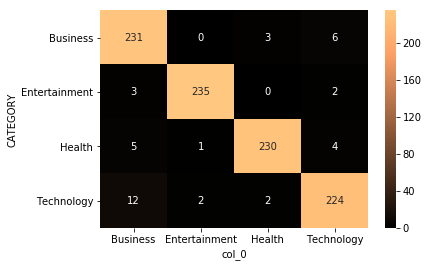

760.1221780776978 seconds.


In [15]:
params = [{
    'solver': ['newton-cg', 'lbfgs', 'sag'],
    'C': [0.3, 0.5, 0.7, 1],
    'penalty': ['l2']
    },{
    'solver': ['liblinear','saga'],
    'C': [0.3, 0.5, 0.7, 1],
    'penalty': ['l1','l2']
}]

lr = LogisticRegression(
    n_jobs=-1 # Use all CPU
)

run_model(lr, params, X_train, y_train, X_test, y_test, features='BOW',i=1)

### 3.3.2 RandomForestClassifier on BoW


 ---------------------------------------- 
 RandomForestClassifier 
 ----------------------------------------
Best parameters: {'criterion': 'entropy'}
Cross-validation stats: mean: 0.93, std: 0.01

Train Accuracy Score: 0.9963815789473685

Test Accuracy Score: 0.9385416666666667


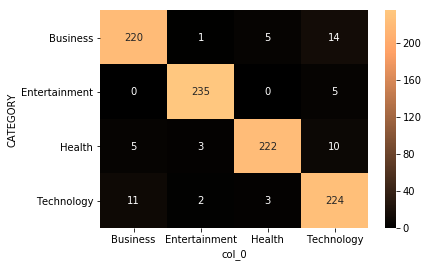

115.88910698890686 seconds.


In [16]:
params = {
    'criterion':['entropy','gini'],
}

# initialize the classifier
rfc = RandomForestClassifier(
    n_estimators=100,
    max_features=None,
    n_jobs=-1,
)

run_model(rfc, params, X_train, y_train, X_test, y_test, features='BOW',i=2)

### 3.3.4 XGBoost on BoW


 ---------------------------------------- 
 XGBClassifier 
 ----------------------------------------


C:\Users\hafeez_poldz\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\hafeez_poldz\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\hafeez_poldz\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\hafeez_poldz\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambig

C:\Users\hafeez_poldz\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\hafeez_poldz\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\hafeez_poldz\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\hafeez_poldz\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambig

C:\Users\hafeez_poldz\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\hafeez_poldz\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Best parameters: {'learning_rate': 0.2, 'max_depth': 5}


C:\Users\hafeez_poldz\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\hafeez_poldz\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\hafeez_poldz\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\hafeez_poldz\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambig

Cross-validation stats: mean: 0.94, std: 0.01


C:\Users\hafeez_poldz\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Train Accuracy Score: 0.96875


C:\Users\hafeez_poldz\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Test Accuracy Score: 0.946875


C:\Users\hafeez_poldz\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


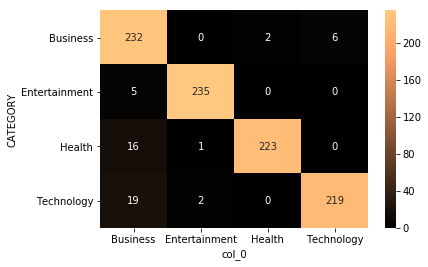

1669.5165615081787 seconds.


In [17]:
max_depth = [3, 5]
learning_rate = [0.1, 0.2, 0.3]

params = dict(max_depth = max_depth, 
              learning_rate = learning_rate)

# initialize the classifier
xgb = xgb.XGBClassifier()

run_model(xgb, params, X_train, y_train, X_test, y_test, features='BOW',i=4)

### 3.3.3 Multi-layer Perceptron on BoW


 ---------------------------------------- 
 MLPClassifier 
 ----------------------------------------
Best parameters: {'activation': 'logistic'}
Cross-validation stats: mean: 0.96, std: 0.0

Train Accuracy Score: 0.9950657894736842

Test Accuracy Score: 0.953125


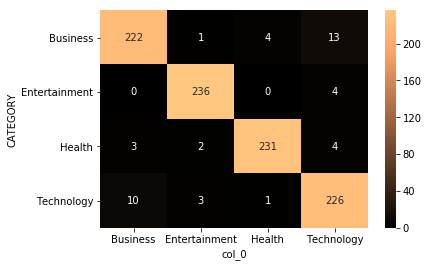

491.8281900882721 seconds.


In [18]:
params = {'activation': ['logistic', 'relu']}

# initialize the classifier
mlp = MLPClassifier(hidden_layer_sizes=(25,))

run_model(mlp, params, X_train, y_train, X_test, y_test, features='BOW',i=3)

### 3.3.5 SVC on BoW


 ---------------------------------------- 
 SVC 
 ----------------------------------------
Best parameters: {'C': 0.01}
Cross-validation stats: mean: 0.66, std: 0.02

Train Accuracy Score: 0.6453947368421052

Test Accuracy Score: 0.6364583333333333


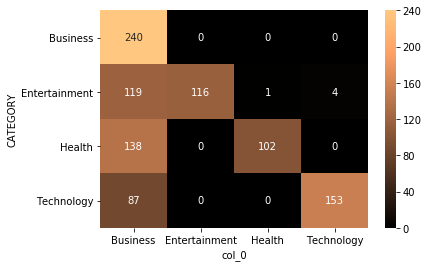

1002.7062306404114 seconds.


In [19]:
Cs = [0.01, 0.1, 1]

params = dict(C=Cs)

# initialize and run the model
svc = SVC(kernel = 'rbf')
run_model(svc, params, X_train, y_train, X_test, y_test, features = 'BOW', i=4)

## Results for Bag-of-Words Feature Generation

In [20]:
report

,Model,n_train,Features,Cross_Val_Mean,Cross_Val_Std,Train_Accuracy,Test_Accuracy
1,LogisticRegression,3040,BOW,0.963487,0.00544505,0.984868,0.958333
2,RandomForestClassifier,3040,BOW,0.928947,0.00573539,0.996382,0.938542
4,XGBClassifier,3040,BOW,0.941447,0.0117963,0.96875,0.946875
3,MLPClassifier,3040,BOW,0.959539,0.00383615,0.995066,0.953125
5,SVC,3040,BOW,0.658882,0.0215605,0.645395,0.636458


# 4. Unsupervised Feature Generation

Different from supervised approach, unsupervised NLP does not require pre-labelled data. As `Unsupervised Feature Generaton` I'll apply `Latent Semantic Analysis` to generate features and fit them to the supervised learning models as I did above. LSA is the process of applying PCA to a tf-idf term-document matrix. In the end we get clusters of terms that presumably reflect a topic. Each document will get a score for each category, with higher scores indicating that the document is relevant to the category. Documents can pertain to more than one category.

## 4.1 Latent Semantic Analysis (LSA)

Latent Semantic Analysis doesn't identify the most common words present in each article as BoW does. But it identifies thematic components present in the text. Each cell doesn't contain a count, but rather a measure of how well a given feature is exemplified by the current document. I'll vectorize BoW headlines to keep the same amount of data for feature generation.

In [21]:
vectorizer = TfidfVectorizer(max_df=0.3, # drop words that occur in more than X percent of documents
                             min_df=9, # only use words that appear at least X times
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case 
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

# pass news headlines to the vectorizer model
counts_tfidf = vectorizer.fit_transform(bow_counts['HEADLINE'])

print("Number of features: %d" % counts_tfidf.get_shape()[1])

Number of features: 617


In [22]:
# reducing the number of features
svd = TruncatedSVD(500)
svd.fit(counts_tfidf)
print('variance captured by all components: ', round(svd.explained_variance_ratio_.sum(),4))

variance captured by all components:  0.9684


In [23]:
lsa = make_pipeline(svd, Normalizer(copy=False))
lsa_data = lsa.fit_transform(counts_tfidf)
lsa_data.shape

(4000, 500)

In [24]:
# create dataset from LSA data
lsa_data = pd.DataFrame(lsa_data)
lsa_data.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.019910,0.006980,0.044239,-0.011416,0.021591,0.368417,0.337042,0.091259,-0.010107,-0.114228,...,0.050925,-0.001168,-0.007392,-0.023926,-0.034212,0.019864,0.002306,-0.018096,-0.019105,-0.010632
1,0.025856,0.009829,0.062334,-0.014910,0.023333,0.511370,0.468213,0.127289,-0.015139,-0.161734,...,-0.002086,-0.003950,-0.001962,0.001263,0.005726,-0.000737,-0.000553,0.001435,-0.002723,-0.001375
2,0.006363,0.006246,0.029082,-0.028987,0.015317,0.334446,0.318393,0.078304,-0.009329,-0.108113,...,-0.008019,-0.009869,-0.008185,-0.016293,0.003405,0.008299,-0.007198,0.016908,-0.015597,-0.009392
3,0.005619,0.005962,0.020358,-0.019276,0.012702,0.264051,0.247799,0.060889,-0.006882,-0.079606,...,-0.017235,0.015092,-0.013406,-0.021657,0.023605,0.029365,0.001898,-0.005370,0.002482,-0.027225
4,0.008640,0.009189,0.038312,-0.040418,0.018512,0.396312,0.327551,0.056066,0.000974,-0.011177,...,-0.009520,-0.017606,0.008392,0.008416,0.009391,0.016709,-0.008548,-0.004016,0.014548,0.007104


## 4.2 Classification on LSA
So we have 500 features to feed the supervised learning algorithms and compare the results for BoW and LSA features.

In [25]:
# define input and output variables
y = bow_counts['CATEGORY']
X = lsa_data

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.24, random_state=0, stratify=y)

X_train.shape

(3040, 500)

### 4.2.1 LogisticRegression on LSA


 ---------------------------------------- 
 LogisticRegression 
 ----------------------------------------
Best parameters: {'C': 1, 'penalty': 'l2', 'solver': 'saga'}
Cross-validation stats: mean: 0.95, std: 0.01

Train Accuracy Score: 0.9710526315789474

Test Accuracy Score: 0.959375


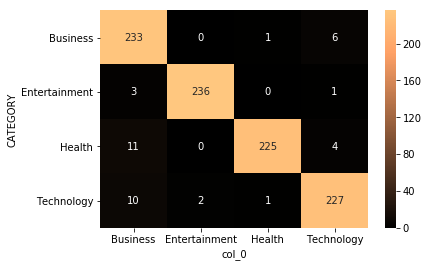

196.317312002182 seconds.


In [26]:
params = [{
    'solver': ['newton-cg', 'lbfgs', 'sag'],
    'C': [0.3, 0.5, 0.7, 1],
    'penalty': ['l2']
    },{
    'solver': ['liblinear','saga'],
    'C': [0.3, 0.5, 0.7, 1],
    'penalty': ['l1','l2']
}]

lr = LogisticRegression(
    n_jobs=-1 # Use all CPU
)

run_model(lr, params, X_train, y_train, X_test, y_test, features='LSA',i=5)

### 4.2.2 RandomForestClassifier on LSA


 ---------------------------------------- 
 RandomForestClassifier 
 ----------------------------------------
Best parameters: {'criterion': 'entropy'}
Cross-validation stats: mean: 0.93, std: 0.01

Train Accuracy Score: 0.9911184210526316

Test Accuracy Score: 0.946875


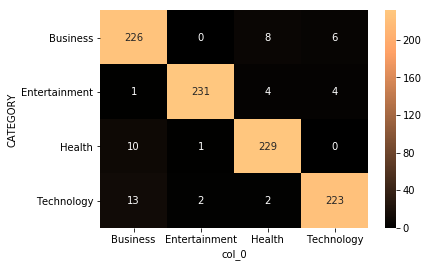

584.4890828132629 seconds.


In [27]:
params = {
    'criterion':['entropy','gini'],
}

# initialize the classifier
rfc = RandomForestClassifier(
    n_estimators=100,
    max_features=None,
    n_jobs=-1,
)

run_model(rfc, params, X_train, y_train, X_test, y_test, features='LSA',i=6)

### 4.2.3 XGBoost on LSA

In [28]:
max_depth = [3, 5]
learning_rate = [0.1, 0.2, 0.3]

params = dict(max_depth = max_depth, 
              learning_rate = learning_rate)

# initialize the classifier
xgb = xgb.XGBClassifier()

run_model(xgb, params, X_train, y_train, X_test, y_test, features='LSA',i=7)

AttributeError: 'XGBClassifier' object has no attribute 'XGBClassifier'

### 4.2.4 Multi-layer Perceptron on LSA

In [ ]:
params = {'activation': ['logistic', 'relu']}

# initialize the classifier
mlp = MLPClassifier(hidden_layer_sizes=(25,))

run_model(mlp, params, X_train, y_train, X_test, y_test, features='LSA',i=8)

In [ ]:
report

## 5. Choosing Model
All the performances of the models are hold in `report` dataframe. To compare algorithms, I'll sort results by `Test_Accuracy`. Second accuracy indicator I'll preferer `Mutual_Info`.

In [ ]:
report.sort_values(by = ['Test_Accuracy', 'Mutual_Info'], ascending = False)

* For all models `n_train` size is 3040
* All the LSA generated feature solutions are at the top
* LogisticRegression classifies the data with the highest accuracy score. 
* Though LogisticRegression predicts with the highest accuracy, MLP Classifier performs almost 3 times faster being the second most accurate model.

# Conclusion

<b>Algorithm</b>
Clearly, LogisticRegression algorithm gives the most accurate predicting results with the both feature generation solutions. However, it is 3 times slower than MLP Classifier. With more nodes and layers, runtime for MLP Classifier might vary, but its accuracy score is very close to the LogisticRegression. 
* Fastest with high accuracy: MLP Classifier
* Most accurate with slower runtime: LogisticRegression

<b>Feature-generation solution</b>

To predict the news categories, classification models on`LSA` features has outperformed `Bag-of-Word`. With less number of features classifiers were faster and more accurate. 
    